###Data loading

In [ ]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.5 MB/s eta 0:00:00


In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d msambare/fer2013

rm: cannot remove '/root/.kaggle': No such file or directory
100% 60.3M/60.3M [00:03<00:00, 23.2MB/s]
100% 60.3M/60.3M [00:03<00:00, 17.2MB/s]


In [ ]:
!mkdir fer2013
!unzip fer2013.zip -d fer2013

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: fer2013/train/sad/Training_65242339.jpg  
  inflating: fer2013/train/sad/Training_65267116.jpg  
  inflating: fer2013/train/sad/Training_65275626.jpg  
  inflating: fer2013/train/sad/Training_6529266.jpg  
  inflating: fer2013/train/sad/Training_65329617.jpg  
  inflating: fer2013/train/sad/Training_65338712.jpg  
  inflating: fer2013/train/sad/Training_65338797.jpg  
  inflating: fer2013/train/sad/Training_65387162.jpg  
  inflating: fer2013/train/sad/Training_65404494.jpg  
  inflating: fer2013/train/sad/Training_65426218.jpg  
  inflating: fer2013/train/sad/Training_65430136.jpg  
  inflating: fer2013/train/sad/Training_65437377.jpg  
  inflating: fer2013/train/sad/Training_6545735.jpg  
  inflating: fer2013/train/sad/Training_65463385.jpg  
  inflating: fer2013/train/sad/Training_65473985.jpg  
  inflating: fer2013/train/sad/Training_65502829.jpg  
  inflating: fer2013/train/sad/Training_65505359.jpg  
  inflatin

In [ ]:
import os
import copy
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils import data
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.optim as optim
from PIL import Image
import numpy as np
from torchvision.datasets import ImageFolder
from torchsummary import summary
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from torcheval.metrics.functional import multiclass_f1_score

In [ ]:
augment_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5)], p=0.5),
    transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
    transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale()
])

In [ ]:
num_classes = 7
path = "./fer2013"
train_dataset = ImageFolder(path+"/train", transform=transform)
augment_dataset = ImageFolder(path+"/train", transform=augment_transform)
train_dataset = ConcatDataset([train_dataset, augment_dataset])
test_dataset = ImageFolder(path+"/test", transform=transform)

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

57418
7178


In [ ]:
images = [image for image, label in [train_dataset[i] for i in range(5)]]
for image in images:
  print(image.shape)

torch.Size([1, 48, 48])
torch.Size([1, 48, 48])
torch.Size([1, 48, 48])
torch.Size([1, 48, 48])
torch.Size([1, 48, 48])


In [ ]:
VALID_RATIO = 0.9
n_train_examples = int(len(train_dataset) * VALID_RATIO)
n_valid_examples = len(train_dataset) - n_train_examples
train_data, valid_data = data.random_split(train_dataset, [n_train_examples, n_valid_examples])
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = transform

In [ ]:
Batch_Size = 128
train_loader = DataLoader(train_data, batch_size=Batch_Size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=Batch_Size, shuffle=False, num_workers=2)
valid_loader = data.DataLoader(valid_data, batch_size=Batch_Size, num_workers=2)

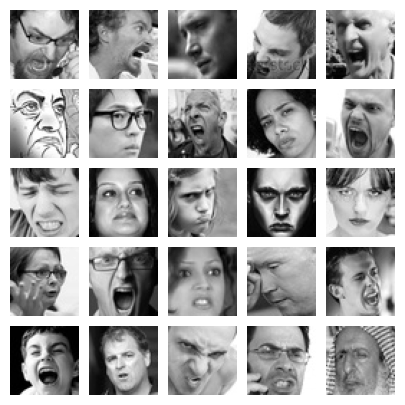

In [ ]:
# get 25 sample training images for visualization
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
dataiter = iter(test_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [ ]:
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###VGG19

In [ ]:
class VGGBlock(nn.Module):
  def __init__(self, in_channels, out_channels, max_pool:bool):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    if max_pool: self.layer.append(nn.MaxPool2d(kernel_size=2, stride=2))

  def forward(self, x):
    return self.layer(x)

class VGGNet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.layer1 = VGGBlock(1, 64, max_pool=False)
    self.layer2 = VGGBlock(64, 64, max_pool=True)
    self.dropout1 = nn.Dropout(p=0.5)

    self.layer3 = VGGBlock(64, 128, max_pool=False)
    self.layer4 = VGGBlock(128, 128, max_pool=True)
    self.dropout2 = nn.Dropout(p=0.5)

    self.layer5 = VGGBlock(128, 256, max_pool=False)
    self.layer6 = VGGBlock(256, 256, max_pool=True)
    self.dropout3 = nn.Dropout(p=0.5)

    self.layer7 = VGGBlock(256, 512, max_pool=False)
    self.layer8 = VGGBlock(512, 512, max_pool=True)
    self.dropout4 = nn.Dropout(p=0.5)

    self.ffn = nn.Sequential(
        nn.Linear(3*3*512, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Linear(1024, num_classes)
    )

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.dropout1(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.dropout2(x)
    x = self.layer5(x)
    x = self.layer6(x)
    x = self.dropout3(x)
    x = self.layer7(x)
    x = self.layer8(x)
    x = self.dropout4(x)
    x = torch.flatten(x, start_dim=1)
    return self.ffn(x)

In [ ]:
vgg = VGGNet(7).to(device)
vgg.name = 'VGG13'

In [ ]:
summary(vgg, (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]             640
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
          VGGBlock-4           [-1, 64, 48, 48]               0
            Conv2d-5           [-1, 64, 48, 48]          36,928
       BatchNorm2d-6           [-1, 64, 48, 48]             128
              ReLU-7           [-1, 64, 48, 48]               0
         MaxPool2d-8           [-1, 64, 24, 24]               0
          VGGBlock-9           [-1, 64, 24, 24]               0
          Dropout-10           [-1, 64, 24, 24]               0
           Conv2d-11          [-1, 128, 24, 24]          73,856
      BatchNorm2d-12          [-1, 128, 24, 24]             256
             ReLU-13          [-1, 128, 24, 24]               0
         VGGBlock-14          [-1, 128,

###ResNet34

In [ ]:
# Define the basic residual block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # Shortcut connection when the input and output dimensions don't match
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=7):
        super(ResNet, self).__init__()
        self.in_planes = 64
        # self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # self.bn1 = nn.BatchNorm2d(64)
        # self.relu = nn.ReLU()
        # self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.shortcut = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(64)
            )

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p = 0.5)
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = self.avgpool(out)
        out = self.dropout(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
def ResNet34(in_channels=1):
    return ResNet(BasicBlock, [2, 4, 9])

# Instantiate the model
resnet34 = ResNet34().to(device)
resnet34.name = 'ResNet34'

In [ ]:
summary(resnet34, (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]             576
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          36,864
       BatchNorm2d-5           [-1, 64, 48, 48]             128
            Conv2d-6           [-1, 64, 48, 48]              64
       BatchNorm2d-7           [-1, 64, 48, 48]             128
              ReLU-8           [-1, 64, 48, 48]               0
            Conv2d-9           [-1, 64, 48, 48]          36,864
      BatchNorm2d-10           [-1, 64, 48, 48]             128
             ReLU-11           [-1, 64, 48, 48]               0
           Conv2d-12           [-1, 64, 48, 48]          36,864
      BatchNorm2d-13           [-1, 64, 48, 48]             128
             ReLU-14           [-1, 64,

###Train & eval & test function

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / Batch_Size
    return acc

In [ ]:
def validation(model, data_loader, loss_fn=None, device=device):
  # if loss_fn is None, return accuracy, else return loss and accuracy
  model.eval()
  with torch.no_grad():
    correct = 0
    total_loss = 0
    total = 0
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        if loss_fn is not None:
          loss = loss_fn(outputs, labels)
          total_loss += loss.item()

        predicted = torch.argmax(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  total_loss = total_loss / total
  if loss_fn is None:
    return acc
  else:
    return acc, total_loss

In [ ]:
def eval(model, data_loader, loss_fn=None, device=device):
  # if loss_fn is None, return accuracy, else return loss and accuracy
  model.eval()
  with torch.no_grad():
    correct = 0
    total_loss = 0
    total = 0
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        if loss_fn is not None:
          loss = loss_fn(outputs, labels)
          total_loss += loss.item()

        predicted = torch.argmax(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  total_loss = total_loss / total
  if loss_fn is None:
    return acc
  else:
    return acc, total_loss

def train(model, train_loader, valid_loader, optimizer, loss_fn, epochs, early_stop_thres=-1, device=device):
  # return history of train loss, train acc, valid loss, valid acc
  assert valid_loader is not None or early_stop_thres == -1, "require valid loader if using early stopping"

  train_loss_ls = []
  train_acc_ls = []
  valid_loss_ls = []
  valid_acc_ls = []

  best_epoch = -1
  best_acc = 0

  for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0

    # Loop over batches
    for batch_idx, (x, y) in enumerate(train_loader):
      # Move variables to device, x is image, y is ground-truth label
      x = x.to(device)
      y = y.to(device)

      optimizer.zero_grad()
      output = model(x)
      loss = loss_fn(output, y)
      train_loss += loss.item()

      predicts = torch.argmax(output.data, dim=1)
      train_correct += (predicts == y).sum().item()

      loss.backward()
      optimizer.step()
    train_loss = train_loss / (batch_idx*Batch_Size)
    train_loss_ls.append(train_loss)

    train_acc = 100 * train_correct / (batch_idx*Batch_Size)
    train_acc_ls.append(train_acc)

    print("Epoch {}".format(epoch+1))
    print("Train loss: {}.\t Train accuracy: {:.2f}%".format(train_loss, train_acc))
    torch.save({
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
    }, f'{model.name}-last.pt')

    if valid_loader is not None:
      valid_acc, valid_loss = eval(model, valid_loader, loss_fn, device=device)
      valid_acc_ls.append(valid_acc)
      valid_loss_ls.append(valid_loss)
      print("Valid loss: {}.\t Valid accuracy: {:.2f}%".format(valid_loss, valid_acc))

      if valid_acc > best_acc:
          best_acc = valid_acc
          best_epoch = epoch
          torch.save(model.state_dict(), f"{model.name}-best.pt")
      if early_stop_thres > -1 and epoch - best_epoch > early_stop_thres:
          print("Early stopped training at epoch %d" % epoch)
          break

  return train_loss_ls, train_acc_ls, valid_loss_ls, valid_acc_ls

In [ ]:
from PIL import Image

def ten_crop_test(image, model):
    # Convert the PyTorch tensor to a PIL Image
    image_list = [transforms.ToPILImage()(image.squeeze(0)) for image in image]

    # Resize the image
    image = transforms.Resize((64, 64))(image)

    # Apply TenCrop
    crops = [transforms.TenCrop(48)(img) for img in image_list] # 10x1x48x48

    # Normalize each crop
    for i in range(len(crops)):
        crops[i] = [transforms.ToTensor()(crop) for crop in crops[i]]

    # Make predictions for each crop
    inputs = [torch.stack(c) for c in crops]
    inputs = torch.stack(inputs).view(-1, 1, 48, 48)  # Reshape for batch processing
    inputs = inputs.to(device)
    outputs = model(inputs)

    # Aggregate predictions (e.g., average or voting)
    final_prediction = outputs.view(len(image_list), 10, -1).mean(dim=1)

    return final_prediction

In [ ]:
def tester(model):
  predicts = torch.zeros(7178, dtype=torch.int64)
  all_labels = torch.zeros(7178, dtype=torch.int64)
  model.eval()
  with torch.no_grad():
      correct = 0
      total = 0
      for i, (images, labels) in enumerate(test_loader):
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          # outputs = ten_crop_test(images, model)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          bound = min((i+1)*Batch_Size, 7178)
          predicts[i*Batch_Size: bound] = predicted.to(torch.int64)
          all_labels[i*Batch_Size: bound] = labels.cpu().to(torch.int64)

      f1 = multiclass_f1_score(predicts, all_labels, average='macro', num_classes=7)

      print('Accuracy of the network on the test dataset: {} %'.format(100 * correct / total))
      print(f'F1 score of the network on test images: {f1:.4f}')

In [ ]:
# optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay = 1e-4, momentum = 0.9)
criteration = nn.CrossEntropyLoss().to(device)

####VGG19 Run

In [ ]:
optimizer = optim.Adam(vgg.parameters())
history = train(vgg, train_loader, valid_loader, optimizer=optimizer, loss_fn = nn.CrossEntropyLoss(), epochs=100, device=device)

NameError: ignored

In [ ]:
tester(vgg)

Accuracy of the network on the test dataset: 69.47617720813597 %
F1 score of the network on test images: 0.6868


####ResNet34 Run

In [ ]:
optimizer = optim.Adam(resnet34.parameters())
history = train(resnet34, train_loader, valid_loader, optimizer=optimizer, loss_fn = nn.CrossEntropyLoss(), epochs=50, device=device)

Epoch 1
Train loss: 0.014744420570527057.	 Train accuracy: 23.99%
Valid loss: 0.014028563747751467.	 Valid accuracy: 26.45%
Epoch 2
Train loss: 0.013061660050735727.	 Train accuracy: 33.23%
Valid loss: 0.012306459333704806.	 Valid accuracy: 40.72%
Epoch 3
Train loss: 0.010739311391011657.	 Train accuracy: 47.40%
Valid loss: 0.010400893566958043.	 Valid accuracy: 49.27%
Epoch 4
Train loss: 0.00962020079639946.	 Train accuracy: 53.59%
Valid loss: 0.009641746493093397.	 Valid accuracy: 53.47%
Epoch 5
Train loss: 0.008969394992759668.	 Train accuracy: 57.03%
Valid loss: 0.009032280384476947.	 Valid accuracy: 56.06%
Epoch 6
Train loss: 0.008439777053837149.	 Train accuracy: 59.72%
Valid loss: 0.008841749134067042.	 Valid accuracy: 57.31%
Epoch 7
Train loss: 0.00807632273756356.	 Train accuracy: 61.68%
Valid loss: 0.008594554949205373.	 Valid accuracy: 58.32%
Epoch 8
Train loss: 0.007709760529684739.	 Train accuracy: 63.47%
Valid loss: 0.00806484345732064.	 Valid accuracy: 61.58%
Epoch 9
Tra

KeyboardInterrupt: ignored

In [ ]:
tester(resnet34)

In [ ]:
EPOCHS = 15
def train_test(model):
  train_loss_list = []
  train_acc_list = []
  val_loss_list = []
  val_acc_list = []
  for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer=optimizer, loss_fn = criteration, device = device)
    valid_loss, valid_acc = validation(model, valid_loader, optimizer=optimizer, loss_fn = criteration, device = device)
    print(f'Epoch: {epoch}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(valid_loss)
    val_acc_list.append(valid_acc)